## Summary

In this examples we will use the [xarray](https://xarray.dev/) and [earthaccess](https://nsidc.github.io/earthaccess/) to subset data and make figures.

## Learning Objectives

1. Extract variables, temporal slices, and spatial slices from an `xarray` dataset 
2. Plot data and exclude data points via boolean conditions, using `xarray`, `cartopy`, and `matplotlib`


### Import Required Packages

In [8]:
# Suppress warnings
import warnings
warnings.simplefilter('ignore')
warnings.filterwarnings('ignore')
from pprint import pprint

import earthaccess
import xarray as xr
xr.set_options(display_expand_attrs=False)
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

%matplotlib inline

## Authenticate to NASA Earthdata

We will authenticate our Earthaccess session, and then open the results like we did in the Search & Discovery section.

In [9]:
# Bug on dhub settings is setting the home to /home/rstudio
import os
os.environ["HOME"] = "/home/jovyan"

In [10]:
auth = earthaccess.login()
# are we authenticated?
if not auth.authenticated:
    # ask for credentials and persist them in a .netrc file
    auth.login(strategy="interactive", persist=True)

EDL_USERNAME and EDL_PASSWORD are not set in the current environment, try setting them or use a different strategy (netrc, interactive)
You're now authenticated with NASA Earthdata Login
Using token with expiration date: 01/29/2024
Using .netrc file for EDL


## Xarray Subsetting - Precipitation estimates from IMERG, Daily Level 3

### Dataset
We will use the GPM IMERG Final Precipitation L3 Daily dataset for this tutorial.  The IMERG Precipitation Rate provides the rain and snow rates in millimeters per hour (mm/hr). It is estimated by the Integrated Multi-satellitE Retrievals for Global Precipitation Measurement (GPM) (IMERG) algorithm. The IMERG algorithm uses passive-microwave data from the GPM constellation of satellites and infrared data from geosynchronous satellites. IMERG “morphs” observations to earlier or later times using wind from weather-model analyses. The daily IMERG dataset is derived from the half-hourly GPM_3IMERGHH. The derived result represents the final estimate of the daily mean precipitation rate in mm/day.

[Link to data on NASA Earthdata](https://search.earthdata.nasa.gov/search?p=C2723754864-GES_DISC&pg%5B0%5D%5Bv%5D=f&pg%5B0%5D%5Bgsk%5D=start_date&q=C2723754864-GES_DISC&tl=1702946000.519%213%21%21)

The IMERG data has 0.1 x 0.1 degree latitude-longitude resolution (approximately 11 by 11 km at the Equator). The grid covers the globe, although precipitation cannot always be estimated near the Poles. The dataset and algorithm are described in the [data user guide](https://gpm1.gesdisc.eosdis.nasa.gov/data/GPM_L3/doc/README.GPM.pdf) and the [Algorithm Theoretical Basis Document (ATBD)](https://arthurhou.pps.eosdis.nasa.gov/Documents/IMERG_V07_ATBD_final.pdf). 

Please cite the dataset as:
> Huffman, G.J., E.F. Stocker, D.T. Bolvin, E.J. Nelkin, Jackson Tan (2023), GPM IMERG Final Precipitation L3 1 day 0.1 degree x 0.1 degree V07, Edited by Andrey Savtchenko, Greenbelt, MD, Goddard Earth Sciences Data and Information Services Center (GES DISC), https://doi.org/10.5067/GPM/IMERGDF/DAY/07

In [15]:
collection_id = 'C2723754864-GES_DISC'  # GPM IMERG Final Precipitation L3 1 day 0.1 degree x 0.1 degree V07 (GPM_3IMERGDF)
# Seems to be a bug in the collection above so I am using older data

# Bounds within which we search for data granules
date_start = "2015-02-25"
date_end = "2015-02-26"
date_range = (date_start, date_end)
bbox = (-127.0761, 31.6444, -113.9039, 42.6310)  # min lon, min lat, max lon, max lat

# For reference (e.g., to visualize in https://geojson.io/), here is a GeoJSON representing the above bounding box:
# {"type": "FeatureCollection", "features": [{"type": "Feature", "properties": {}, "geometry": {"type": "LineString", "bbox": [-127.0761, 31.6444, -113.9039, 42.631], "coordinates": [[-113.9039, 42.631], [-127.0761,42.631], [-127.0761, 31.6444], [-113.9039, 31.6444], [-113.9039, 42.631]]}}]}

results = earthaccess.search_data(
    concept_id = collection_id,
    cloud_hosted = True,
    temporal = date_range,
    bounding_box = bbox,
)

Granules found: 2


In [16]:
ds = xr.open_mfdataset(earthaccess.open(results))

 Opening 2 granules, approx size: 0.05 GB


SUBMITTING | :   0%|          | 0/2 [00:00<?, ?it/s]

PROCESSING | :   0%|          | 0/2 [00:00<?, ?it/s]

COLLECTING | :   0%|          | 0/2 [00:00<?, ?it/s]

Note that `xarray` works with "lazy" computation whenever possible. In this case, the metadata are loaded into JupyterHub memory, but the data arrays and their values are not — until there is a need for them.

Let's print out all the variable names.

In [17]:
for v in ds.variables:
    print(v)

precipitation
precipitation_cnt
precipitation_cnt_cond
MWprecipitation
MWprecipitation_cnt
MWprecipitation_cnt_cond
randomError
randomError_cnt
probabilityLiquidPrecipitation
lon
lat
time
time_bnds


Of the variables listed above, we are interested in three variables: `precipitation`, `precipitation_cnt_cond`, and `probabilityLiquidPrecipitation`. Let's print their attributes.

In [26]:
ds.variables['precipitation'].attrs

{'units': 'mm/day',
 'long_name': 'Daily mean precipitation rate (combined microwave-IR) estimate. Formerly precipitationCal.'}

In [27]:
ds.variables['precipitation_cnt_cond'].attrs

{'units': 'count',
 'long_name': 'Count of half-hourly precipitation retrievals for the day where precipitation is at least 0.01 mm/hr'}

In [28]:
ds.variables['probabilityLiquidPrecipitation'].attrs

{'units': 'percent',
 'long_name': 'Probability of liquid precipitation',
 'description': 'Probability of liquid precipitation estimated with a diagnostic parameterization using ancillary data. 0=missing values; 1=likely solid; 100=likely liquid or no precipitation.  Screen by positive precipitation or precipitation_cnt_cond to locate meaningful probabilities.'}

### Subsetting

In addition to directly accessing the files archived and distributed by each of the NASA DAACs, many datasets also support services that allow us to customize the data via subsetting, reformatting, reprojection/regridding, and file aggregation. What does subsetting mean? To **subset** means to extract only the portions of a dataset that are needed for a given purpose. 

There are three primary types of subsetting that we will walk through: 
1. Temporal
2. Spatial
3. Variable

In each case, we will be excluding parts of the dataset that are not wanted using `xarray`. Note that "subsetting" is also called a data "transformation".

In [29]:
ds.time.values

array(['2015-02-25T00:00:00.000000000', '2015-02-26T00:00:00.000000000'],
      dtype='datetime64[ns]')

We start with a subset that represents the U.S. state of California.  Notice the dimensions of the Dataset and each variable — time, lon, lat, and 'nv' (number of vertices) for the bounds variable.

In [30]:
# Display the full dataset's metadata
ds

<xarray.Dataset>
Dimensions:                         (time: 2, lon: 3600, lat: 1800, nv: 2)
Coordinates:
  * lon                             (lon) float32 -179.9 -179.9 ... 179.9 179.9
  * lat                             (lat) float64 -89.95 -89.85 ... 89.85 89.95
  * time                            (time) datetime64[ns] 2015-02-25 2015-02-26
Dimensions without coordinates: nv
Data variables:
    precipitation                   (time, lon, lat) float32 dask.array<chunksize=(1, 3600, 1800), meta=np.ndarray>
    precipitation_cnt               (time, lon, lat) int8 dask.array<chunksize=(1, 3600, 1800), meta=np.ndarray>
    precipitation_cnt_cond          (time, lon, lat) int8 dask.array<chunksize=(1, 3600, 1800), meta=np.ndarray>
    MWprecipitation                 (time, lon, lat) float32 dask.array<chunksize=(1, 3600, 1800), meta=np.ndarray>
    MWprecipitation_cnt             (time, lon, lat) int8 dask.array<chunksize=(1, 3600, 1800), meta=np.ndarray>
    MWprecipitation_cnt_cond        (time, lon, lat) int8 dask.array<chunksize=(1, 3600, 1800), meta=np.ndarray>
    randomError                     (time, lon, lat) float32 dask.array<chunksize=(1, 3600, 1800), meta=np.ndarray>
    randomError_cnt                 (time, lon, lat) int8 dask.array<chunksize=(1, 3600, 1800), meta=np.ndarray>
    probabilityLiquidPrecipitation  (time, lon, lat) int8 dask.array<chunksize=(1, 3600, 1800), meta=np.ndarray>
    time_bnds                       (time, nv) datetime64[ns] dask.array<chunksize=(1, 2), meta=np.ndarray>
Attributes: (9)

Now we will prepare a subset. We're using essentially the same spatial bounds as above; however, as opposed to the `earthaccess` inputs above, here we must provide inputs in the formats expected by `xarray`. Instead of a single, four-element, bounding box, we use Python `slice` objects, which are defined by starting and ending numbers.

In [36]:
ds_subset = ds.sel(time=date_start, lat=slice(31, 43), lon=slice(-125, -113)) 
ds_subset

<xarray.Dataset>
Dimensions:                         (lon: 120, lat: 120, nv: 2)
Coordinates:
  * lon                             (lon) float32 -124.9 -124.8 ... -113.1
  * lat                             (lat) float64 31.05 31.15 ... 42.85 42.95
    time                            datetime64[ns] 2015-02-25
Dimensions without coordinates: nv
Data variables:
    precipitation                   (lon, lat) float32 dask.array<chunksize=(120, 120), meta=np.ndarray>
    precipitation_cnt               (lon, lat) int8 dask.array<chunksize=(120, 120), meta=np.ndarray>
    precipitation_cnt_cond          (lon, lat) int8 dask.array<chunksize=(120, 120), meta=np.ndarray>
    MWprecipitation                 (lon, lat) float32 dask.array<chunksize=(120, 120), meta=np.ndarray>
    MWprecipitation_cnt             (lon, lat) int8 dask.array<chunksize=(120, 120), meta=np.ndarray>
    MWprecipitation_cnt_cond        (lon, lat) int8 dask.array<chunksize=(120, 120), meta=np.ndarray>
    randomError                     (lon, lat) float32 dask.array<chunksize=(120, 120), meta=np.ndarray>
    randomError_cnt                 (lon, lat) int8 dask.array<chunksize=(120, 120), meta=np.ndarray>
    probabilityLiquidPrecipitation  (lon, lat) int8 dask.array<chunksize=(120, 120), meta=np.ndarray>
    time_bnds                       (nv) datetime64[ns] dask.array<chunksize=(2,), meta=np.ndarray>
Attributes: (9)

Notice the differences?

### Plotting

We will first plot using the methods built-in to the `xarray` package.

Note that, as opposed to the "lazy" loading of metadata previously, this will now perform "eager" computation, pulling the required data chunks.

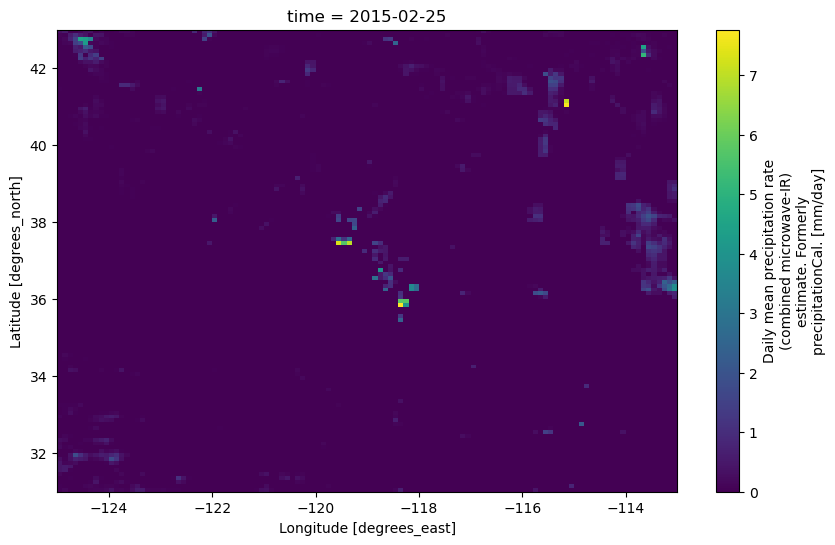

In [33]:
ds_subset['precipitation'].plot(figsize=(10,6), x='lon', y='lat');

Now let's utilize the "Probability of liquid precipitation phase" (`probabilityLiquidPrecipitation`) variable to split apart the snow precipitation from everything else. From the variable's description attribute, we can see that "0=missing values; 1=likely solid; 100=likely liquid or no precipitation".

Moreover, we'll utilize `precipitation_cnt_cond` to filter out data points that had less than 0.01 mm/hr preciptation amounts.

In [34]:
snow = ds_subset['precipitation'].where(
    (ds_subset.precipitation_cnt_cond>0) & (ds_subset.probabilityLiquidPrecipitation == 1)
)

prcp = ds_subset['precipitation'].where(
    (ds_subset.precipitation_cnt_cond>0) & (ds_subset.probabilityLiquidPrecipitation != 1)
)

In the following plotting commands, we utilize `cartopy` and `matplotlib` to generate a more customized figure. 

`cartopy` is used to set the map projection (to PlateCarree) and to add U.S. state boundary lines to the figure. `matplotlib`'s pcolormesh is used to generate the color plot, with colors determined by the third argument's value.

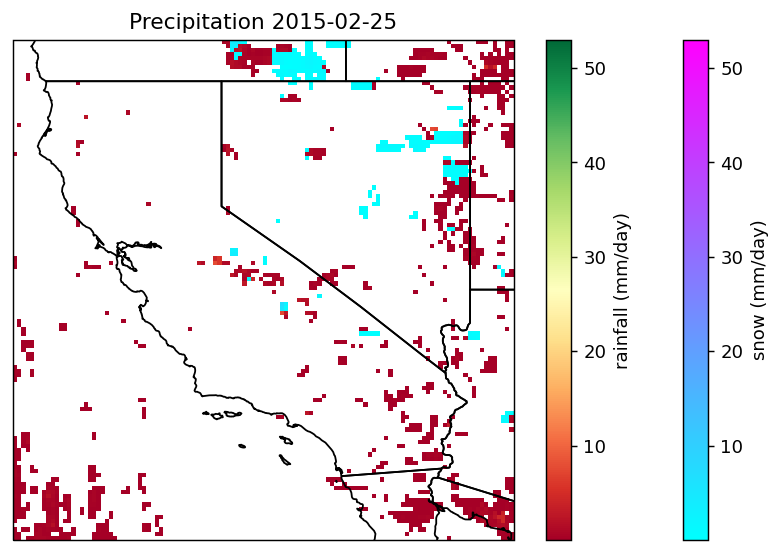

In [35]:
# create the plot
proj = ccrs.PlateCarree()
fig, ax = plt.subplots(figsize=(8,5), dpi=130, facecolor="w", subplot_kw=dict(projection=proj))

snowax = plt.pcolormesh(prcp.lon, prcp.lat, snow.squeeze(), vmax=53, cmap='cool')
prcpax = plt.pcolormesh(prcp.lon, prcp.lat, prcp.squeeze(), vmax=53, cmap='RdYlGn')

plt.colorbar(snowax, ax=ax, label="snow (mm/day)")
plt.colorbar(prcpax, ax=ax, label="rainfall (mm/day)")
ax.add_feature(cfeature.STATES)
ax.set_extent([-125, -113.0, 31.0, 43.0], crs=proj)
ax.set_title(f'Precipitation {date_start}')

plt.show()

Notice the enhancements?

Also, note that you can explore these (and other) data before generating your own customized plots, by using NASA Worldview. [Here's a link](https://worldview.earthdata.nasa.gov/?v=-156.13974252713064,12.501303538340089,-58.87926564851792,62.28255353834009&l=Reference_Labels_15m(hidden),Reference_Features_15m(hidden),Coastlines_15m,IMERG_Precipitation_Rate,VIIRS_NOAA20_CorrectedReflectance_TrueColor(hidden),VIIRS_SNPP_CorrectedReflectance_TrueColor(hidden),MODIS_Aqua_CorrectedReflectance_TrueColor(hidden),MODIS_Terra_CorrectedReflectance_TrueColor(hidden)&lg=true&t=2023-02-24-T10%3A00%3A00Z) to an example map on Worldview for these IMERG data.

END of Notebook.